# Finding fast growing firms, Mukhamejan Assan
Task: to build a model to predict fast growth of firms 

* Using the bisnode-firms data https://osf.io/3qyut
* Design the target (fast growth), it can be measured in any way: over one (2013 vs 2012) or two years (2014 vs 2012)
* Need to argue for choice, discussing a few alternatives.
* Build three different models and pick the favorite
* Should include at least one logit and one random forest


# EDA, target and feature engineering

In [1021]:
# import packages
import pandas as pd
import numpy as np
import sys
import warnings # Hide warnings
warnings.filterwarnings('ignore')

import patsy

from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import seaborn as sns
from mizani.formatters import percent_format
import regex as re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

In [1022]:
# Load data
data = pd.read_csv("./data_raw/cs_bisnode_panel.csv")

# Filter the data to include only the values where the year falls within the range of 2010 to 2014, inclusive.
data = data[(data['year'] >= 2010) & (data['year'] <= 2014)]

In [1023]:
# Missing values

# Calculate the percentage of missing values for each variable
missing_percentages = (data.isna().sum() / len(data)) * 100

# Sort the variables based on the percentage of missing values, in descending order
missing_percentages_sorted = missing_percentages.sort_values(ascending=False)

# Create a table that shows the variable names and their corresponding percentage of missing values
missing_table = pd.DataFrame({'Variable': missing_percentages_sorted.index, 'Missing %': missing_percentages_sorted.values})

# Drop variables that are missing 90% of their values
data.drop(missing_table.Variable[missing_table['Missing %'] >= 90].to_list(), axis=1, inplace=True)

# Print the names and number of variables that were dropped
print(len(missing_table.Variable[missing_table['Missing %'] >= 90]), "variables are dropped:", missing_table.Variable[missing_table['Missing %'] >= 90].to_list())

6 variables are dropped: ['D', 'finished_prod', 'wages', 'COGS', 'net_exp_sales', 'net_dom_sales']


## Target engineering

To define the target variable, I will first calculate the percentage change in sales for each firm over a specific period of time. I will then classify firms as "fast-growing" if their percentage change in sales exceeds a certain threshold, which I define to be 

Defining fast-growing firms based on percentage change in sales makes sense because it provides a quantitative measure of growth that can be easily calculated and compared across firms. It also allows us to identify firms that are experiencing rapid growth, which can be valuable information for investors, stakeholders, and business decision makers.

In [1024]:
# Replace values in 'sales' variable that are less than or equal to 0 with 1
data['sales'] = np.where((data['sales'] <= 0) & (~data['sales'].isnull()), 1, data['sales'])

# Create 'ln_sales' variable
data['ln_sales'] = np.where(data['sales'].notnull(), np.log(data['sales']), np.nan)

# Calculate changes of ln_sales from 2011 to 2012 for each company
data['diff_ln_sales'] = data['ln_sales'] - data.groupby('comp_id')['ln_sales'].shift(1)

# Create age variable and new binary variable based on age and balsheet_notfullyear
data['age'] = np.where(data['year'] - data['founded_year'] < 0, 0, data['year'] - data['founded_year'])
data['new'] = np.where(((data['age'] <= 1) | (data['balsheet_notfullyear'] == 1)), 1, np.where(data['age'].isna(), np.nan, 0))

# Adjust diff_ln_sales and new variables based on new variable
data["diff_ln_sales"] = np.where(data["new"].isna(), data["diff_ln_sales"], np.where(data["new"] == 1, 0, data["diff_ln_sales"]))
data["new"] = np.where(data["diff_ln_sales"].isna(), 1, data["new"])
data["diff_ln_sales"] = np.where(data["diff_ln_sales"].isna(), 0, data["diff_ln_sales"])

# Calculate the sales growth in both years
data['sales_growth_2012_2013'] = data.groupby('comp_id')['sales'].pct_change()
data['sales_growth_2013_2014'] = data.groupby('comp_id')['sales'].pct_change(periods=2)

# Calculate the 75th percentile of sales growth in both years
sales_growth_75th_percentile_2012_2013 = data['sales_growth_2012_2013'].quantile(0.75)
sales_growth_75th_percentile_2013_2014 = data['sales_growth_2013_2014'].quantile(0.75)

# Generate 'status_alive' variable: if sales larger than 1 and not-NA, then firm is alive.
data['status_alive'] = np.where((data['sales'] > 0) & (~data['sales'].isna()), 1, 0)

# Filter the data to only include observations where the year is 2012 and the company is alive,
# and where the sales value is between 1000 euros and 10 million euros
data = data.query('year == 2012 and status_alive == 1 and 0.001 <= sales/1000000 <= 10')

# Update the 'fast_growth' variable to include only companies in the top 25% by sales growth in both years
data['fast_growth'] = np.where(
    (data['sales_growth_2012_2013'] >= sales_growth_75th_percentile_2012_2013) &
    (data['sales_growth_2013_2014'] >= sales_growth_75th_percentile_2013_2014),
    1, 0)

print(f"Total number of companies: {data['comp_id'].nunique()}\nNumber of fast-growing companies: {data[data['fast_growth']==1]['comp_id'].nunique()}\nShare of fast-growing companies: {data[data['fast_growth']==1]['comp_id'].nunique()/data['comp_id'].nunique()*100:.2f}%")

Total number of companies: 21723
Number of fast-growing companies: 2531
Share of fast-growing companies: 11.65%


## Feature Engineering

In [1025]:
# Create a new column called 'ind2_cat' that copies the values from 'ind2'
data['ind2_cat'] = data['ind2'].copy()

# Re-encode industries
data['ind2_cat']=data['ind2'].copy()
data['ind2_cat']=np.where(data['ind2']>56,60,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']<26,20,data['ind2_cat'])
data['ind2_cat']=np.where((data['ind2']<55)&(data['ind2']>35),40,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2']==31,30,data['ind2_cat'])
data['ind2_cat']=np.where(data['ind2'].isna(),99,data['ind2_cat'])

# Firm characteristics
data['age2'] = data['age'] ** 2
data['foreign_management'] = (data['foreign'] >= 0.5).astype(int)
data['gender_m'] = pd.Categorical(data['gender'], categories=['female', 'male', 'mix'], ordered=True)
data['m_region_loc'] = pd.Categorical(data['region_m'], categories=['Central', 'East', 'West'], ordered=True)

########################################################################
# Financial variables
########################################################################

# Assets can't be negative. Change them to 0 and add a flag.
data['flag_asset_problem'] = np.where((data['intang_assets']<0) | (data['curr_assets']<0) | (data['fixed_assets']<0), 1, 0)
data['flag_asset_problem'].value_counts()

data['intang_assets'] = np.where(data['intang_assets']<0, 0, data['intang_assets'])
data['curr_assets'] = np.where(data['curr_assets']<0, 0, data['curr_assets'])
data['fixed_assets'] = np.where(data['fixed_assets']<0, 0, data['fixed_assets'])

# Generate total assets
data['total_assets_bs'] = data['intang_assets'] + data['curr_assets'] + data['fixed_assets']
data['total_assets_bs'].describe()

pl_names = ['extra_exp', 'extra_inc', 'extra_profit_loss', 'inc_bef_tax', 'inventories',
            'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
            'share_eq', 'subscribed_cap', 'tang_assets']

# divide all pl_names elements by sales and create new column for it
data[[col + '_pl' for col in pl_names]] = data[pl_names].div(data['sales'], axis='index')

# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + '_bs' for col in bs_names]] = data[bs_names].div(data['total_assets_bs'], axis='index').replace([np.inf, -np.inf, np.nan], 0)

In [1026]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = ['extra_exp_pl', 'extra_inc_pl', 'inventories_pl', 'material_exp_pl', 'personnel_exp_pl',
           'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'subscribed_cap_bs',
           'intang_assets_bs']

data[[col +'_flag_high' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] > 1).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero]))
data[[col +'_flag_error' for col in zero]] = np.where(data[zero].isna(), np.nan, (data[zero] < 0).astype(int))
data[[col for col in zero]] = np.where(data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero]))

# for vars that could be any, but are mostly between -1 and 1
anyof = ['extra_profit_loss_pl', 'inc_bef_tax_pl', 'profit_loss_year_pl', 'share_eq_bs']

data[[col +'_flag_low' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof]))
data[[col +'_flag_high' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int))
data[[col for col in anyof]] = np.where(data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof]))
data[[col +'_flag_zero' for col in anyof]] = np.where(data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int))
data[[col +'_quad' for col in anyof]] = np.where(data[anyof].isna(), np.nan, data[anyof]**2)

# dropping flags with no variation
flag_columns = [col for col in data.columns if 'flag' in col]
data = data.drop(data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1)


In [1027]:
# additional
# including some imputation

# CEO age
data['ceo_age'] = data['year'] - data['birth_year']
data['flag_low_ceo_age'] = np.where((data['ceo_age'] < 25) & (~data['ceo_age'].isna()), 1, 0)
data['flag_high_ceo_age'] = np.where((data['ceo_age'] > 75) & (~data['ceo_age'].isna()), 1, 0)
data['flag_miss_ceo_age'] = np.where(data['ceo_age'].isna(), 1, 0)

mean_age = data['ceo_age'].mean(skipna=True)
data['ceo_age'] = np.where((data['ceo_age'] < 25), 25, data['ceo_age'])
data['ceo_age'] = np.where((data['ceo_age'] > 75), 75, data['ceo_age'])
data['ceo_age'] = np.where(data['ceo_age'].isna(), mean_age, data['ceo_age'])
data['ceo_young'] = np.where((data['ceo_age'] < 40), 1, 0)

# number emp, very noisy measure
mean_labor_avg = data['labor_avg'].mean(skipna=True)
data['labor_avg_mod'] = np.where(data['labor_avg'].isna(), mean_labor_avg, data['labor_avg'])
data['flag_miss_labor_avg'] = np.where(data['labor_avg'].isna(), 1, 0)

# create factors
data['urban_m'] = pd.Categorical(data['urban_m'], categories=[1, 2, 3], ordered=False)
data['ind2_cat'] = pd.Categorical(data['ind2_cat'], categories=np.sort(data['ind2_cat'].unique()), ordered=False)
data['fast_growth_cat'] = pd.Categorical(data['fast_growth'], categories=[0, 1], ordered=False).rename_categories(['no_fast_growth', 'fast_growth'])

# Square log of sales
data['ln_sales_sq'] = data['ln_sales']**2


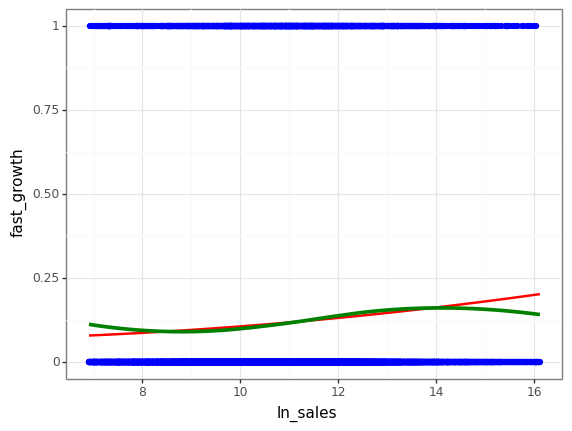

<ggplot: (8782736620460)>

In [1028]:
ggplot(data, aes(x = "ln_sales", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color='red', se = False) + geom_smooth(
    method = "loess", color='green', se = False, size=1.5, span=0.9) + labs(
    x="ln_sales", y="fast_growth"
) + theme_bw()

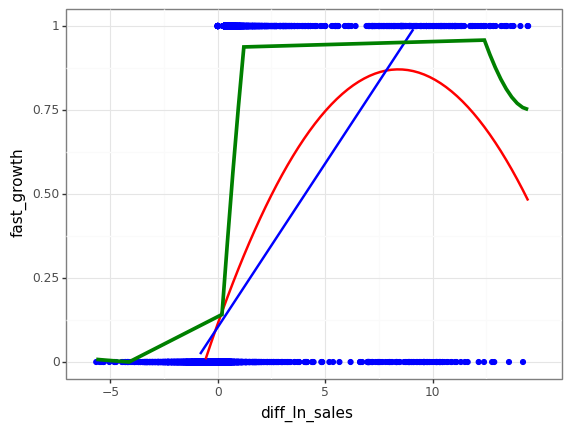

<ggplot: (8782717165680)>

In [1029]:
ggplot(data, aes(x = "diff_ln_sales", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color='red', se = False) + geom_smooth(
    method='lm', formula='y ~ x',  color='blue', se = False) + geom_smooth(
    method = "loess", color='green', se = False, size=1.5, span=0.9) + labs(
    x="diff_ln_sales", y="fast_growth" ) + scale_x_continuous(
    limits=(-6, 15), breaks = range(-5, 15, 5))+ scale_y_continuous(
    limits=(0, 1)
    ) + theme_bw()

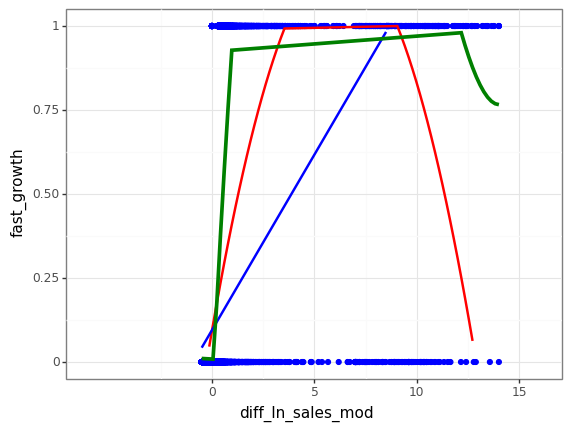

<ggplot: (8782717445979)>

In [1030]:
# generate winsorized variables 

data['flag_low_diff_ln_sales'] = np.where(data['diff_ln_sales'] < -0.5, 1, 0)
data['flag_high_diff_ln_sales'] = np.where(data['diff_ln_sales'] > 14, 1, 0)
data['diff_ln_sales_mod'] = np.where(data['diff_ln_sales'] < -0.5, -0.5, 
                                        np.where(data['diff_ln_sales'] > 14, 14, data['diff_ln_sales']))
data['diff_ln_sales_mod_sq'] = data['diff_ln_sales_mod']**2
ggplot(data, aes(x = "diff_ln_sales_mod", y = "fast_growth")) + geom_point(
    color = 'blue') + geom_smooth(
    method='lm', formula='y ~ x + I(x**2)',  color='red', se = False) + geom_smooth(
    method='lm', formula='y ~ x',  color='blue', se = False) + geom_smooth(
    method = "loess", color='green', se = False, size=1.5, span=0.9) + labs(
    x="diff_ln_sales_mod", y="fast_growth" ) + scale_x_continuous(
    limits=(-6, 16), breaks = range(0, 16, 5))+ scale_y_continuous(
    limits=(0, 1)
    ) + theme_bw()

In [1031]:
data = data.dropna(subset = ['liq_assets_bs', 'foreign', 'ind','age', 'foreign', 'material_exp_pl', 'm_region_loc', 'profit_loss_year_pl'])
# drop unnecessary columns
data = data.reset_index()
data = data.drop(['index', 'exit_date' , 'birth_year', 'exit_year'], axis=1)

# Probability prediction

## Helper functions

In [1032]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def coef_matrix(X, model):

    coef_matrix = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix = coef_matrix.append({'variable': 'Intercept', 'coefficient': np.asscalar(model.intercept_)}, ignore_index=True)
    return(coef_matrix)

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color="black", size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = np.arange(0, 1.1, 0.1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = np.arange(0, 1.1, 0.1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color="black", size=0.7) + \
        scale_x_continuous(breaks = np.arange(0, 1.1, 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = "blue" ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour="red", angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color="black", size=0.7) +\
        scale_y_continuous(breaks = np.arange(0, 1.1, 0.1)) +\
        scale_x_reverse(breaks = np.arange(0, 1.1, 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

In [1033]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap", "amort"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3=[]
for col in data.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["diff_ln_sales_mod", "diff_ln_sales_mod_sq",
         "flag_low_diff_ln_sales", "flag_high_diff_ln_sales"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [1034]:
#Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)",data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(['C(ind2_cat)[26.0]'], axis=1)

# Get the variance of each variable
variances = ind2_catmat.var()

# Get the names of variables with 0 variance
zero_variance_vars = variances[variances == 0].index.tolist()

print("Variables with 0 variance:", zero_variance_vars)

# Drop the variables with 0 variance
ind2_catmat = ind2_catmat.drop(zero_variance_vars, axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1]'], axis=1)

Variables with 0 variance: ['C(ind2_cat)[20.0]', 'C(ind2_cat)[32.0]', 'C(ind2_cat)[40.0]', 'C(ind2_cat)[60.0]', 'C(ind2_cat)[99.0]']


In [1035]:
# Define X1
basevars = data[["ln_sales", "ln_sales_sq", "diff_ln_sales_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars, ind2_catmat], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["ln_sales", "ln_sales_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["ln_sales", "ln_sales_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [1036]:
# Define X5
#Creat matrix for interactions1 variables
int1mat = patsy.dmatrix("0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):diff_ln_sales_mod \
                + C(ind2_cat):ln_sales + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod", data, return_type="dataframe")
#Drop first level to get k-1 dummies out of k categorical levels 
for col in int1mat.columns:
    if col.startswith('C(ind2_cat)[26.0]') or col.endswith('C(urban_m)[1.0]'):
        int1mat = int1mat.drop([col], axis=1)
        
#Creat matrix for interactions2 variables        
int2mat = patsy.dmatrix("0 + ln_sales:age + ln_sales:female + ln_sales:profit_loss_year_pl \
                + ln_sales:foreign_management", data, return_type="dataframe")
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [1037]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales", "diff_ln_sales"] + rawvars + hr + qualityvars], firm], axis=1)

y = data['fast_growth']

## Check simple linear and logistic models

In [1038]:
# X1 - OLS
ols_modelx1 = LinearRegression().fit(X1, y)
print(regression_results(y, ols_modelx1.predict(X1)))

# X1 - Logit
glm_modelx1 = LogisticRegression(solver="newton-cg",max_iter=1000, penalty="none").fit(X1, y)
print(regression_results(y, glm_modelx1.predict(X1)))

# X2 - Logit
glm_modelx2 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X2, y)
print(regression_results(y, glm_modelx2.predict(X2)))

explained_variance:  0.2087
r2:  0.2087
MAE:  0.1726
MSE:  0.083
RMSE:  0.2882
None
explained_variance:  0.137
r2:  0.076
MAE:  0.097
MSE:  0.097
RMSE:  0.3114
None
explained_variance:  0.141
r2:  0.0815
MAE:  0.0964
MSE:  0.0964
RMSE:  0.3105
None


In [1039]:
mx2 = sm.Logit(y,sm.add_constant(X2)).fit().get_margeff()
mx2.summary()

Optimization terminated successfully.
         Current function value: 0.271829
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
ln_sales                    0.0508      0.013      4.013      0.000       0.026       0.076
ln_sales_sq                -0.0016      0.001     -2.929      0.003      -0.003      -0.001
diff_ln_sales_mod           0.1370      0.004     36.175      0.000       0.130       0.144
profit_loss_year_pl         0.0739      0.008      9.162      0.000       0.058       0.090
C(ind2_cat)[27.0]           0.0111      0.013      0.835      0.404      -0.015       0.037
C(ind2_cat)[28.0]          -0.0008      0.011     -0.077      0.938      -0.022       0.020
C(ind2_cat)[29.0]          -0.0295      0.020     -1.439      0.150      -0.070       0.011
C(ind2_cat)[30.0]          -0.0063      0.023     -0.273      0.785      -0.052       0.039
C(ind2_cat)[33.0]          -0.0123      0.011     -1.128      0.259      -0.034       0.009
C(ind2_cat)[55.0]           0.0186      0.011      1.766      0.077      -0.002       0.039
C(ind2_cat)[56.0]          -0.0149      0.009     -1.582      0.114      -0.033       0.004
fixed_assets_bs             0.0131      0.007      1.954      0.051   -4.17e-05       0.026
share_eq_bs                -0.0140      0.005     -2.617      0.009      -0.025      -0.004
curr_liab_bs                0.0222      0.009      2.486      0.013       0.005       0.040
curr_liab_bs_flag_high     -0.0138      0.008     -1.767      0.077      -0.029       0.002
curr_liab_bs_flag_error     0.1301      0.069      1.896      0.058      -0.004       0.265
age                        -0.0023      0.000     -6.983      0.000      -0.003      -0.002
foreign_management          0.0033      0.006      0.515      0.606      -0.009       0.016
===========================================================================================
"""

In [1040]:
# Check model X3
glm_modelx3 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X3, y)
regression_results(y, glm_modelx3.predict(X3))

explained_variance:  0.2787
r2:  0.2562
MAE:  0.0781
MSE:  0.0781
RMSE:  0.2794


In [1041]:
# Check model X4
glm_modelx4 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X4, y)
regression_results(y, glm_modelx4.predict(X4))

explained_variance:  0.2918
r2:  0.2707
MAE:  0.0765
MSE:  0.0765
RMSE:  0.2767


In [1042]:
# Check model X5
glm_modelx5 = LogisticRegression(solver="newton-cg", max_iter=1000, penalty="none").fit(X5, y)
regression_results(y, glm_modelx5.predict(X5))

explained_variance:  0.311
r2:  0.2912
MAE:  0.0744
MSE:  0.0744
RMSE:  0.2727


## Separate train and holdout data

In [1043]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.8*len(data.index)), random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [1044]:
print('Total')
print(data['fast_growth'].value_counts(normalize=True))
print('Train')
print(data.iloc[index_train]['fast_growth'].value_counts(normalize=True))
print('Holdout')
print(data.iloc[index_holdout]['fast_growth'].value_counts(normalize=True))

#specify cross-validation method
k = KFold(n_splits=5, shuffle=True, random_state=42)

Total
0    0.880857
1    0.119143
Name: fast_growth, dtype: float64
Train
0    0.880426
1    0.119574
Name: fast_growth, dtype: float64
Holdout
0    0.882585
1    0.117415
Name: fast_growth, dtype: float64


# Predict Probabilities

## Logit models

In [1045]:
# no regularisation needed so setting the paremeter to very high value
C_value_logit=[1e20]

# Train Logit Models ----------------------------------------------
logit_model_vars = [X1.iloc[index_train], X2.iloc[index_train], X3.iloc[index_train], X4.iloc[index_train], X5.iloc[index_train]]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='neg_brier_score', 
                            solver="newton-cg", tol=1e-7, random_state=42)
    logit_models['X'+str(i+1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds['X'+str(i+1)] = np.sqrt(-1*(logit_models['X'+str(i+1)].scores_[1])).tolist()

In [1046]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

lambdas=list(10**np.arange(-1,-4.01, -1/3))
n_obs = normalized_logitvars.shape[0]*4/5
C_values = [1/(l*n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='accuracy', solver='liblinear',
                             random_state=42)

logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.886861
1,0.046416,0.001768,0.888963
2,0.021544,0.003810,0.893428
3,0.010000,0.008208,0.903080
4,0.004642,0.017684,0.911091
5,0.002154,0.038098,0.916213
6,0.001000,0.082080,0.919562
7,0.000464,0.176837,0.921532
8,0.000215,0.380983,0.921794
9,0.000100,0.820802,0.921794


In [1047]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [1048]:
coef_matrix(normalized_logitvars, logit_models["LASSO"])

,variable,coefficient
0,ln_sales,0.620612
1,ln_sales_sq,0.000000
2,total_assets_bs,-0.027006
3,fixed_assets_bs,0.041341
4,liq_assets_bs,0.095476
...,...,...
211,ln_sales:age,-0.255836
212,ln_sales:female,0.000000
213,ln_sales:profit_loss_year_pl,0.162268
214,ln_sales:foreign_management,-0.011454


In [1049]:
#refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='neg_brier_score', 
                            solver="liblinear", random_state=42)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['LASSO'] = np.sqrt(-1*(logLasso_brier_fitted.scores_[1][:,i])).tolist()

In [1050]:
CV_RMSE_wo_loss = dict()

for key in logit_models:
    CV_RMSE_wo_loss[key] = np.mean(CV_RMSE_folds[key])

summary_results = pd.DataFrame({
    "Model": list(CV_RMSE_folds.keys()),
    "CV RMSE": list(CV_RMSE_wo_loss.values())
                               })
summary_results

,Model,CV RMSE
0,X1,0.265422
1,X2,0.264928
2,X3,0.253916
3,X4,0.252929
4,X5,0.239479
5,LASSO,0.235788


In [1051]:
# # Calculate AUC for each folds --------------------------------
# CV_AUC_folds = dict()

# #refit logit models with AUC so we have AUC values for the same cv split
# for i in range(len(logit_model_vars)):
#     LRCV_auc = LogisticRegressionCV(Cs=C_value_logit, cv=k, refit=True, scoring='roc_auc', 
#                             solver="newton-cg", tol=1e-7, random_state=42)
#     LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
#     # Calculate AUC on test for each fold
#     CV_AUC_folds['X'+str(i+1)] = LRCV_auc_fit.scores_[1][:,0].tolist()

# #refit with AUC so we have AUC values for the same cv split
# logLasso_auc = LogisticRegressionCV(Cs=C_values, penalty='l1', cv=k, refit=True, scoring='roc_auc', 
#                             solver="liblinear", random_state=42)
# logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
# CV_AUC_folds['LASSO'] = logLasso_auc_fitted.scores_[1][:,best_lambda_i].tolist()

# # For each model: average RMSE and average AUC for models ----------------------------------
# CV_RMSE = dict()
# CV_AUC = dict()
# nvars = dict()

# for key in logit_models:
#     CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
#     CV_AUC[key] = np.mean(CV_AUC_folds[key])
    
# for key in logit_models:
#     if key != 'LASSO':
#         nvars[key] = logit_models[key].n_features_in_
#     else:
#         nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

# # We have 6 models, (5 logit and the logit lasso). For each we have a 5-CV RMSE and AUC.
# # We pick our preferred model based on that. -----------------------------------------------
# logit_summary1 = np.transpose(pd.DataFrame.from_dict([nvars,CV_RMSE,CV_AUC], orient='columns'))
# logit_summary1.columns = ['Number of predictors', 'CV RMSE', 'CV AUC']

# logit_summary1

In [1052]:
# # Take best model and estimate RMSE on holdout  -------------------------------------------
# # X4, X5 and LASSO are practically the same - go with the simplest model 

# best_model = logit_models['X1']
# best_model_X_holdout = X1.iloc[index_holdout]

# logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[:,1]
# best_rmse_holdout = np.sqrt(metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout))
# round(best_rmse_holdout, 3)

In [1053]:
# # discrete ROC (with thresholds in steps) on holdout -------------------------------------------------

# thresholds = np.arange(0.05, 0.85, 0.05)
# cm = dict()
# true_positive_rates = []
# false_positive_rates = []
# holdout_prediction = []
# for thr in thresholds:
#     holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
#     cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
#     cm[thr] = cm_thr
#     tn, fp, fn, tp = cm_thr.ravel()
#     true_positive_rates.append(tp/(tp+fn))
#     false_positive_rates.append(fp/(fp+tn))

# tpr_fpr_for_thresholds = pd.DataFrame(
#     {'thresholds': thresholds,
#      'true_positive_rates': true_positive_rates,
#      'false_positive_rates': false_positive_rates})

# ggplot(tpr_fpr_for_thresholds, aes(x = 'false_positive_rates', y = 'true_positive_rates', color='thresholds'))\
#         + labs(x = "False positive rate (1 - Specificity)", y = "True positive rate (Sensitivity)")\
#         + geom_point(size=2, alpha=0.8) + scale_color_continuous(trans = 'reverse')\
#         + scale_x_continuous(limits=(0,1), breaks = np.arange(0, 1.01, 0.1))\
#         + scale_y_continuous(limits=(0,1), breaks = np.arange(0, 1.01, 0.1))\
#         + theme_bw()\
#         +theme(legend_position="right",
#             axis_text=element_text(size=5),
#             axis_title=element_text(size=5),
#             legend_text = element_text(size = 4),
#             legend_title = element_text(size = 4),
#             legend_key_size=6)

In [1054]:
# # continuous ROC on holdout with best model (Logit 4) -------------------------------------------

# create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [1055]:
# # Confusion table with different tresholds ----------------------------------------------------------

# # default: the threshold 0.5 is used to convert probabilities to binary classes
# logit_class_prediction = best_model.predict(best_model_X_holdout)

# values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
# print(values[0],' (no fast growth): ',counts[0])
# print(values[1],' (fast growth): ',counts[1])

# # confusion matrix: summarize different type of errors and successfully predicted cases
# # positive = "yes": explicitly specify the positive case
# cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0,1])
# cm1 = pd.DataFrame(cm_object1, 
#     index=['Actual not fast-growing', 'Actual fast-growing'], 
#     columns=['Predicted not fast-growing', 'Predicted fast-growing'])
# cm1


## Without the Loss Function

In [1056]:
features = [
    X1, X2, X3, X4, X5, logitvars, rfvars
]

In [1057]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

# Define the features

features = [X1, X2, X3, X4, X5, logitvars, rfvars]

# Split the data into training and holdout sets
index_train, index_holdout = train_test_split(data.index.values, train_size=0.8, random_state=42)
data_train = data.loc[index_train]
data_holdout = data.loc[index_holdout]

# Define the target variable
y_train = data_train['fast_growth']

# Define the Logit models for X1 to X5
logit_models = []
for i in range(5):
    logit_model = LogisticRegression(penalty='none', solver='newton-cg')
    logit_model.fit(features[i].loc[index_train], y_train)
    logit_models.append(logit_model)

# Define the LASSO model for logitvars
scaler = StandardScaler()
logitvars_scaled = scaler.fit_transform(logitvars)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso_model.fit(logitvars_scaled[index_train], y_train)
selected_vars = SelectFromModel(lasso_model, prefit=True).get_support()
logitvars_selected = logitvars.iloc[:, selected_vars]

# Evaluate the models using cross-validation and report the results in a table
results = []
for i, model in enumerate(logit_models):
    cv_results = cross_validate(model, features[i].loc[index_train], y_train, scoring=['neg_mean_squared_error', 'roc_auc'], cv=5)
    cv_rmse = np.sqrt(-cv_results['test_neg_mean_squared_error'].mean())
    cv_auc = cv_results['test_roc_auc'].mean()
    results.append({'Model': f'Logit {i+1}', 'CV RMSE': cv_rmse, 'CV AUC': cv_auc})

cv_results = cross_validate(lasso_model, logitvars_scaled[index_train], y_train, scoring=['neg_mean_squared_error', 'roc_auc'], cv=5)
cv_rmse = np.sqrt(-cv_results['test_neg_mean_squared_error'].mean())
cv_auc = cv_results['test_roc_auc'].mean()
results.append({'Model': 'LASSO', 'CV RMSE': cv_rmse, 'CV AUC': cv_auc})

results_df = pd.DataFrame(results)

In [1058]:
results_df

,Model,CV RMSE,CV AUC
0,Logit 1,0.313748,0.939321
1,Logit 2,0.312699,0.934533
2,Logit 3,0.309216,0.950325
3,Logit 4,0.309322,0.946731
4,Logit 5,0.289244,0.948381
5,LASSO,0.280015,0.946883


In [1059]:
# Define the features for X3
X3_holdout = X3.iloc[index_holdout]

# Define the target variable for the holdout set
y_holdout = data_holdout['fast_growth']

# Use the predict_proba method of the fitted logistic regression model for X3 to obtain the predicted probabilities for the holdout set
y_pred_proba_holdout = logit_models[2].predict_proba(X3_holdout)[:, 1]

# Calculate the RMSE between the predicted probabilities and the true values for the holdout set
rmse_holdout = np.sqrt(mean_squared_error(y_holdout, y_pred_proba_holdout))

print(f"RMSE for X3 on holdout set: {rmse_holdout:.4f}")


RMSE for X3 on holdout set: 0.2487


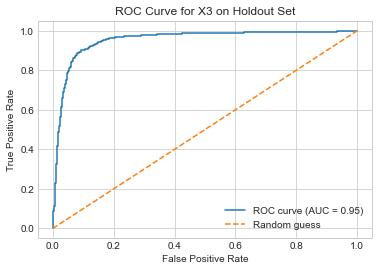

In [1060]:
# Import necessary libraries
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Use the predict_proba method of the fitted logistic regression model for X3 to obtain the predicted probabilities for the holdout set
y_pred_proba_holdout = logit_models[2].predict_proba(X3_holdout)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values for the predicted probabilities and true labels
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_proba_holdout)

# Calculate the area under the curve (AUC)
auc = roc_auc_score(y_holdout, y_pred_proba_holdout)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for X3 on Holdout Set')
plt.legend(loc="lower right")
plt.show()


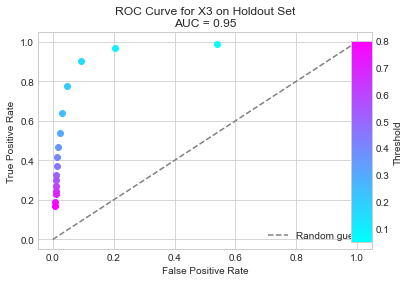

In [1061]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Use the predict_proba method of the fitted logistic regression model for X3 to obtain the predicted probabilities for the holdout set
y_pred_proba_holdout = logit_models[2].predict_proba(X3_holdout)[:, 1]

# Define the threshold values
thresholds = np.arange(0.05, 0.85, 0.05)

# Calculate the false positive rate (FPR), true positive rate (TPR) for the threshold values
fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba_holdout)

# Create a colormap based on the threshold values
cmap = plt.get_cmap('cool')
norm = plt.Normalize(vmin=min(thresholds), vmax=max(thresholds))

# Plot the ROC curve with varying thresholds
fig, ax = plt.subplots()
for i in range(len(thresholds)):
    idx = np.argmin(abs(thresholds[i] - _))
    ax.plot(fpr[idx], tpr[idx], 'o', color=cmap(norm(thresholds[i])))

# Add a colorbar next to the plot
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cb.set_label('Threshold')

# Plot the random guess line and the AUC value
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
auc = roc_auc_score(y_holdout, y_pred_proba_holdout)
ax.set_title('ROC Curve for X3 on Holdout Set\nAUC = {:.2f}'.format(auc))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")

plt.show()


In [1062]:
# Use the predict_proba method of the fitted logistic regression model for X3 to obtain the predicted probabilities for the holdout set
y_pred_proba_holdout = logit_models[2].predict_proba(X3_holdout)[:, 1]

# Calculate the mean predicted probability for fast growth in the holdout set
mean_predicted_fast_growth_prob = np.mean(y_pred_proba_holdout)

# Use the mean predicted probability as a threshold to classify the predicted probabilities as either 0 or 1
holdout_prediction = np.where(y_pred_proba_holdout < mean_predicted_fast_growth_prob, 0, 1)

# Build the confusion matrix with the holdout set
cm_object = confusion_matrix(y_holdout, holdout_prediction, labels=[0,1])
cm = pd.DataFrame(cm_object, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])

cm

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,2828,533
Actual fast-growing,24,423


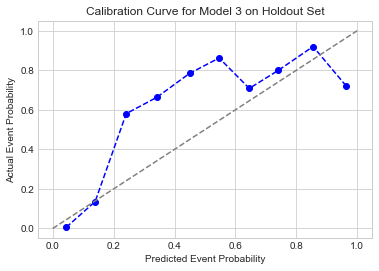

In [1063]:
# Use the predict_proba method of the fitted logistic regression model for X3 to obtain the predicted probabilities for the holdout set
y_pred_proba_holdout = logit_models[2].predict_proba(X3_holdout)[:, 1]

# Calculate the mean predicted probability for fast growth in the holdout set
mean_predicted_fast_growth_prob = np.mean(y_pred_proba_holdout)

# Use the mean predicted probability as a threshold to classify the predicted probabilities as either 0 or 1
holdout_prediction = np.where(y_pred_proba_holdout < mean_predicted_fast_growth_prob, 0, 1)

# Create a DataFrame with actual and predicted probabilities
df_calib = pd.DataFrame({'y_true': y_holdout, 'y_pred': y_pred_proba_holdout})

# Group the DataFrame by predicted probabilities and calculate the mean of actual probabilities
df_calib = df_calib.groupby(pd.cut(df_calib['y_pred'], np.arange(0, 1.1, 0.1))).mean()

# Plot the calibration curve
fig, ax = plt.subplots()
ax.plot(df_calib['y_pred'], df_calib['y_true'], linestyle='--', marker='o', markersize=6, color='b')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('Calibration Curve for Model 3 on Holdout Set')
ax.set_xlabel('Predicted Event Probability')
ax.set_ylabel('Actual Event Probability')
plt.show()


## With the Loss Function

In [1064]:
fast_growth_median_sales_growth = data[['comp_id', 'fast_growth', 'sales_growth_2012_2013']].groupby(['comp_id', 'fast_growth']).median().loc[(slice(None), 1), 'sales_growth_2012_2013'].median()
non_fast_growth_median_sales_growth = data[['comp_id', 'fast_growth', 'sales_growth_2012_2013']].groupby(['comp_id', 'fast_growth']).median().loc[(slice(None), 0), 'sales_growth_2012_2013'].median()

print('Median sales growth for fast-growing firms:', round(fast_growth_median_sales_growth, 3))
print('Median sales growth for non-fast-growing firms:', round(non_fast_growth_median_sales_growth, 3))

cost_of_false_positive = 1+round(fast_growth_median_sales_growth, 3)
cost_of_false_negative = 1+round(non_fast_growth_median_sales_growth, 3)

prevalence = data['fast_growth'].mean()


Median sales growth for fast-growing firms: 0.973
Median sales growth for non-fast-growing firms: -0.018


In [1065]:
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, feature in enumerate(features):
    if i < 5:
        model = LogisticRegression(penalty='none', solver='newton-cg')
    else:
        scaler = StandardScaler()
        feature = scaler.fit_transform(feature)
        model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
        feature = SelectFromModel(model.fit(feature, y), prefit=True).transform(feature)
    
    scores = cross_val_score(model, feature, y, cv=5, scoring='roc_auc')
    y_pred_prob = cross_val_predict(model, feature, y, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    best_thresholds_cv[f'X{i+1}' if i < 5 else 'Lasso'] = optimal_threshold
    
    threshold_prediction = np.where(y_pred_prob < optimal_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y, threshold_prediction, labels=[0, 1]).ravel()
    expected_loss = (fp * cost_of_false_positive * (1 - prevalence) +
                     fn * cost_of_false_negative * prevalence) / len(y)
    expected_loss_cv[f'X{i+1}' if i < 5 else 'Lasso'] = expected_loss
    
    # for fold #5
    fold5_threshold[f'X{i+1}' if i < 5 else 'Lasso'] = optimal_threshold
    
    all_coords = pd.DataFrame({
        'false_pos': fpr * sum(y == 0),
        'true_pos': tpr * sum(y == 1),
        'false_neg': sum(y == 1) - tpr * sum(y == 1),
        'true_neg': sum(y == 0) - fpr * sum(y == 0),
        'pos': sum(y == 1),
        'neg': sum(y == 0),
        'n': len(y),
        'thresholds': thresholds
    })
    
    fold5_all_coords[f'X{i+1}' if i < 5 else 'Lasso'] = all_coords


In [1066]:
table_data = {'Model': [], 'Avg of optimal thresholds': [], 'Threshold for Fold5': [], 'Avg expected loss': [], 'Expected loss for Fold5': []}

for i, feature in enumerate(features):
    if i < 5:
        model = LogisticRegression(penalty='none', solver='newton-cg')
    else:
        scaler = StandardScaler()
        feature = scaler.fit_transform(feature)
        model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
        feature = SelectFromModel(model.fit(feature, y), prefit=True).transform(feature)
    
    scores = cross_val_score(model, feature, y, cv=5, scoring='roc_auc')
    y_pred_prob = cross_val_predict(model, feature, y, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    best_thresholds_cv[f'X{i+1}' if i < 5 else 'Lasso'] = optimal_threshold
    
    threshold_prediction = np.where(y_pred_prob < optimal_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y, threshold_prediction, labels=[0, 1]).ravel()
    expected_loss = (fp * cost_of_false_positive * (1 - prevalence) +
                     fn * cost_of_false_negative * prevalence) / len(y)
    expected_loss_cv[f'X{i+1}' if i < 5 else 'Lasso'] = expected_loss
    
    # for fold #5
    fold5_threshold[f'X{i+1}' if i < 5 else 'Lasso'] = optimal_threshold
    
    all_coords = pd.DataFrame({
        'false_pos': fpr * sum(y == 0),
        'true_pos': tpr * sum(y == 1),
        'false_neg': sum(y == 1) - tpr * sum(y == 1),
        'true_neg': sum(y == 0) - fpr * sum(y == 0),
        'pos': sum(y == 1),
        'neg': sum(y == 0),
        'n': len(y),
        'thresholds': thresholds
    })
    
    fold5_all_coords[f'X{i+1}' if i < 5 else 'Lasso'] = all_coords


In [1067]:
fold5_expected_loss = {}

for model_name, coords in fold5_all_coords.items():
    threshold = fold5_threshold[model_name]
    pred = np.where(y_pred_prob < threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y, pred, labels=[0, 1]).ravel()
    expected_loss = (fp * cost_of_false_positive * (1 - prevalence) +
                     fn * cost_of_false_negative * prevalence) / len(y)
    fold5_expected_loss[model_name] = expected_loss

table_data = {
    'Model': [],
    'Avg of optimal thresholds': [],
    'Threshold for Fold5': [],
    'Avg expected loss': [],
    'Expected loss for Fold5': []
}

# populate the table data
for i in range(len(features)):
    model_name = f'X{i+1}' if i < 5 else 'Lasso'
    table_data['Model'].append(model_name)
    table_data['Avg of optimal thresholds'].append(np.mean(best_thresholds_cv[model_name]))
    table_data['Threshold for Fold5'].append(fold5_threshold.get(model_name, ''))
    table_data['Avg expected loss'].append(np.mean(expected_loss_cv[model_name]))
    table_data['Expected loss for Fold5'].append(fold5_expected_loss.get(model_name, ''))

table_df = pd.DataFrame(table_data)
# drop the last row of table_df
table_df = table_df.drop(table_df.index[-1])

In [1068]:
table_df

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,0.134463,0.134463,0.164905,0.239336
1,X2,0.139795,0.139795,0.157538,0.219788
2,X3,0.142053,0.142053,0.177398,0.211541
3,X4,0.134797,0.134797,0.191888,0.237887
4,X5,0.135483,0.135483,0.172077,0.235167
5,Lasso,0.138962,0.138962,0.222471,0.222471


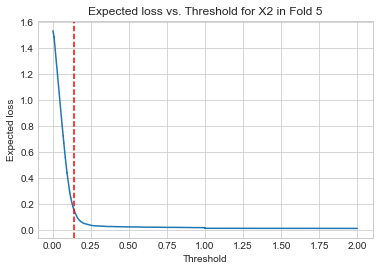

In [1069]:
model_name = 'X2'
threshold_fold5 = fold5_threshold[model_name]
coords_fold5 = fold5_all_coords[model_name]
x = coords_fold5['thresholds']
loss = ((coords_fold5['false_pos'] * cost_of_false_positive * (1 - prevalence) +
         coords_fold5['false_neg'] * cost_of_false_negative * prevalence) / len(y))
plt.plot(x, loss)
plt.axvline(threshold_fold5, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Expected loss')
plt.title(f'Expected loss vs. Threshold for {model_name} in Fold 5')
plt.show()


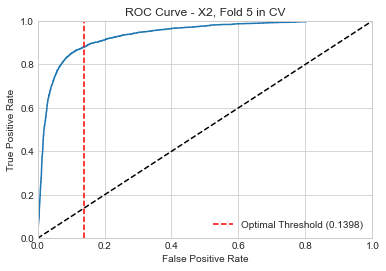

In [1070]:
# get the data for model 2
model_name = 'X2'
coords = fold5_all_coords[model_name]

# calculate true positive rate and false positive rate
tpr = coords['true_pos'] / coords['pos']
fpr = coords['false_pos'] / coords['neg']

# calculate optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = coords.loc[optimal_idx, 'thresholds']

# plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {model_name}, Fold 5 in CV')

# add the optimal threshold as a vertical line
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.4f})')
plt.legend(loc='lower right')
plt.show()


In [1071]:
best_model = table_df.sort_values(by='Avg expected loss').iloc[0]['Model']
print("Best model based on average expected loss:", best_model)

Best model based on average expected loss: X2


In [1072]:
# Pick best model based on average expected loss ----------------------------------
best_model = table_df.loc[table_df['Avg expected loss'].idxmin(), 'Model']
best_threshold = best_thresholds_cv['X2']

# Get expected loss on holdout
holdout_treshold = np.where(y_pred_proba_holdout < best_threshold, 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*cost_of_false_positive*(1-prevalence) + fn*cost_of_false_negative*prevalence)/len(y_holdout)
round(expected_loss_holdout, 3)

0.171

In [1073]:
cm3 = pd.DataFrame(confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]), 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])

cm3

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,2988,373
Actual fast-growing,41,406


# Prediction with random forest

In [1074]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

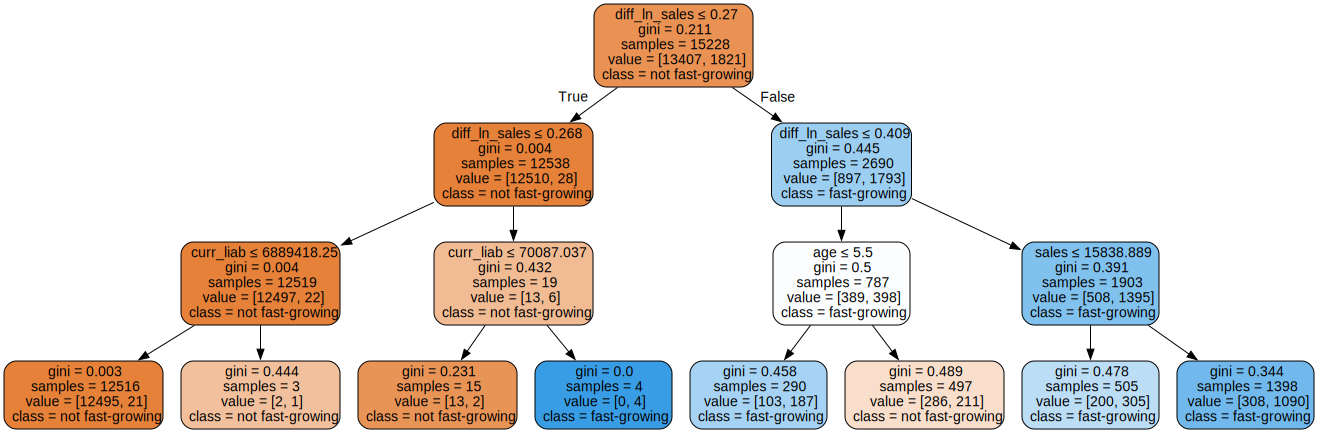

In [1075]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

# create decision tree classifier
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(rfvars_train, y_train)

# plot decision tree
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=rfvars_train.columns,  
                                class_names=['not fast-growing', 'fast-growing'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph


## Random forest

In [1076]:
# Define grid of hyperparameters to search over
grid = {
    'max_features': [5, 6, 7],
    'criterion': ['gini'],
    'min_samples_split': [11, 16]
}

# Define the random forest classifier model
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)

# Define the grid search object
prob_forest_grid = GridSearchCV(
    prob_forest, 
    grid, 
    cv=k, 
    refit='accuracy',
    scoring=['accuracy', 'roc_auc', 'neg_brier_score'], 
    n_jobs=-1
)

# Fit the grid search to the training data
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)


In [1077]:
# Create CV summary table
cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = cv_accuracy + prob_forest_fit.cv_results_['split' + str(i) + '_test_accuracy']
cv_accuracy = cv_accuracy/5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5

prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

prob_forest_cv_results


,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.944379,0.977452,0.197259
1,5,16,0.943722,0.977401,0.197960
2,6,11,0.944182,0.977697,0.194728
3,6,16,0.946086,0.977766,0.194870
4,7,11,0.944313,0.978012,0.192817
5,7,16,0.945232,0.977672,0.193282


In [1078]:
# Get the best hyperparameters
best_mtry = prob_forest_fit.best_params_['max_features']
best_min_node_size = prob_forest_fit.best_params_['min_samples_split']

# Get average (i.e. over the folds) RMSE and AUC
prob_forest_best_results = prob_forest_cv_results[    (prob_forest_cv_results.max_features == best_mtry) &     (prob_forest_cv_results.min_samples_split == best_min_node_size)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

# Get fold-level RMSE and AUC
CV_RMSE_folds_rf_p = []
for i in range(5):
    rmse = np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds['rf_p'] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = []
for i in range(5):
    rmse = prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc'][prob_forest_best_results_index]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds['rf_p'] = CV_AUC_folds_rf_p


In [1079]:
cost = cost_of_false_negative/cost_of_false_positive
cost

0.4977192093258997

In [1080]:
best_thresholds_rf_p = []
expected_loss_rf_p = []

cost = cost_of_false_negative/cost_of_false_positive

for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index,:]
    y_fold = y_train.iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index,:]
    y_fold_train = y_train.iloc[train_index]

    prob_forest_best = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                    criterion = 'gini', max_features = best_mtry, min_samples_split = best_min_node_size)
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(list(zip(np.abs(true_pos_rate + (1 - prevalence)/(cost * prevalence)*(1-false_pos_rate)), threshold)), key=lambda x: x[0], reverse=True)[0][1]
    best_thresholds_rf_p.append(best_threshold)
    
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
    curr_exp_loss = (fp*cost_of_false_positive + fn*cost_of_false_negative)/len(y_fold)
    expected_loss_rf_p.append(curr_exp_loss)

all_coords_rf_p = pd.DataFrame({
    'false_pos': false_pos_rate * sum(y_fold == 0),
    'true_pos': true_pos_rate * sum(y_fold == 1),
    'false_neg': sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
    'true_neg': sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
    'pos': sum(y_fold == 1),
    'neg': sum(y_fold == 0),
    'n': len(y_fold),
    'thresholds': threshold
})

expected_loss_cv['rf_p'] = np.mean(expected_loss_rf_p)
best_thresholds_cv['rf_p'] = np.mean(best_thresholds_rf_p)

rf_summary = pd.DataFrame(
    {'CV RMSE': [round(CV_RMSE['rf_p'], 3)],
     'CV AUC': [round(CV_AUC['rf_p'], 3)],
     'Avg of optimal thresholds': [round(best_thresholds_cv['rf_p'], 3)],
     'Threshold for Fold5': [round(best_thresholds_rf_p[4], 3)],
     'Avg expected loss': [round(expected_loss_cv['rf_p'], 3)],
     'Expected loss for Fold5': [round(expected_loss_rf_p[4], 3)]})


In [1081]:
expected_loss_rf_p

[0.07915397242284965,
 0.07695929087327642,
 0.07397504924491136,
 0.06655533661740558,
 0.07788111658456486]

In [1082]:
rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.195,0.978,0.569,0.609,0.075,0.078


In [1083]:
all_coords_rf_p

,false_pos,true_pos,false_neg,true_neg,pos,neg,n,thresholds
0,0.0,0.0,355.0,2690.0,355,2690,3045,1.850456
1,0.0,1.0,354.0,2690.0,355,2690,3045,0.850456
2,0.0,21.0,334.0,2690.0,355,2690,3045,0.796123
3,1.0,21.0,334.0,2689.0,355,2690,3045,0.794551
4,1.0,23.0,332.0,2689.0,355,2690,3045,0.792705
...,...,...,...,...,...,...,...,...
249,2594.0,355.0,0.0,96.0,355,2690,3045,0.000100
250,2597.0,355.0,0.0,93.0,355,2690,3045,0.000095
251,2599.0,355.0,0.0,91.0,355,2690,3045,0.000091
252,2600.0,355.0,0.0,90.0,355,2690,3045,0.000087


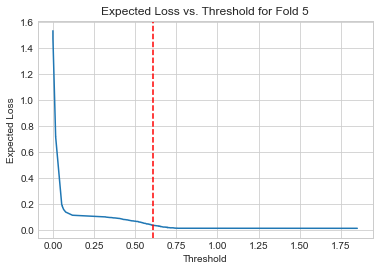

In [1084]:
import matplotlib.pyplot as plt

# Extract relevant data
thresholds = all_coords_rf_p['thresholds']
false_pos = all_coords_rf_p['false_pos']
false_neg = all_coords_rf_p['false_neg']
pos = all_coords_rf_p['pos']

# Calculate loss for each threshold
loss = (false_pos*cost_of_false_positive*(1-prevalence) + false_neg*cost_of_false_negative*prevalence) / len(y_fold)

# Find best threshold
optimal_threshold = best_thresholds_rf_p[4]

# Create plot
plt.plot(thresholds, loss)
plt.axvline(optimal_threshold, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Expected Loss')
plt.title('Expected Loss vs. Threshold for Fold 5')
plt.show()


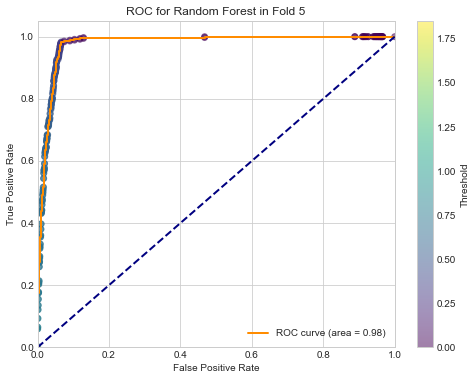

In [1085]:
from sklearn.metrics import roc_auc_score, roc_curve

# # calculate the false positive rate, true positive rate, and threshold for the 5th fold
# X_fold = rfvars_train.iloc[test_index,:]
# y_fold = y_train.iloc[test_index]

prob_forest_best = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True,
                criterion = 'gini', max_features = best_mtry, min_samples_split = best_min_node_size)
prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:,1]

false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
best_threshold = sorted(list(zip(np.abs(true_pos_rate + (1 - prevalence)/(cost * prevalence)*(1-false_pos_rate)), threshold)), key=lambda x: x[0], reverse=True)[0][1]

# plot the ROC curve with the optimal threshold for the 5th fold
fpr, tpr, _ = roc_curve(y_fold, pred_fold)
roc_auc = roc_auc_score(y_fold, pred_fold)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(false_pos_rate, true_pos_rate, c=threshold, cmap='viridis', alpha=0.5)
plt.colorbar(label='Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Random Forest in Fold 5')
plt.legend(loc="lower right")
plt.show()


In [1086]:
# Take model to holdout and estimate RMSE, AUC and expected loss
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.193

In [1087]:
# ROC AUC  on holdout
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.974

In [1088]:
# Get expected loss on holdout
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*cost_of_false_positive + fn*cost_of_false_negative)/len(y_holdout)
round(expected_loss_holdout, 3)

0.081

In [1089]:
cm_object4 = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1])
cm4 = pd.DataFrame(cm_object4, 
    index=['Actual not fast-growing', 'Actual fast-growing'], 
    columns=['Predicted not fast-growing', 'Predicted fast-growing'])
cm4

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3277,84
Actual fast-growing,144,303


In [1090]:
nvars['rf_p'] = len(rfvars.columns)

summary_results = pd.DataFrame({"Model": list(nvars.keys()),
                              "Number of predictors": list(nvars.values()),
                              "CV RMSE": list(CV_RMSE.values()),
                              "CV AUC": list(CV_AUC.values()),
                              "CV threshold": list(best_thresholds_cv.values()),
                              "CV expected Loss": list(expected_loss_cv.values())
                               })

In [1091]:
summary_results

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.265422,0.940740,0.134463,0.164905
1,X2,18,0.264928,0.934609,0.139795,0.157538
2,X3,35,0.253916,0.949581,0.142053,0.177398
3,X4,79,0.252929,0.947439,0.134797,0.191888
4,X5,215,0.239479,0.950254,0.135483,0.172077
5,LASSO,118,0.235788,0.948957,0.138962,0.222471
6,rf_p,45,0.194870,0.977766,0.568556,0.074905


Overall the best result is delivered by random forest classifier. This model achives the lowest RMSE, the highest AUC, and the least expected loss. Moreover, the number of variables is decent in comparison with the rest of the models.

In [1092]:
cm4 # Random Forest

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,3277,84
Actual fast-growing,144,303


In [1093]:
cm3 # Model 2

,Predicted not fast-growing,Predicted fast-growing
Actual not fast-growing,2988,373
Actual fast-growing,41,406
